Epoch 1/100
7/7 [==============================] - 1s 24ms/step - loss: 0.2495 - val_loss: 0.2450
Epoch 2/100
7/7 [==============================] - 0s 5ms/step - loss: 0.2412 - val_loss: 0.2339
Epoch 3/100
7/7 [==============================] - 0s 5ms/step - loss: 0.2283 - val_loss: 0.2164
Epoch 4/100
7/7 [==============================] - 0s 5ms/step - loss: 0.2074 - val_loss: 0.1889
Epoch 5/100
7/7 [==============================] - 0s 5ms/step - loss: 0.1745 - val_loss: 0.1477
Epoch 6/100
7/7 [==============================] - 0s 6ms/step - loss: 0.1264 - val_loss: 0.0928
Epoch 7/100
7/7 [==============================] - 0s 5ms/step - loss: 0.0677 - val_loss: 0.0395
Epoch 8/100
7/7 [==============================] - 0s 5ms/step - loss: 0.0251 - val_loss: 0.0163
Epoch 9/100
7/7 [==============================] - 0s 5ms/step - loss: 0.0160 - val_loss: 0.0068
Epoch 10/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0053 - val_loss: 0.0035
Epoch 11/100
7/7 [==========

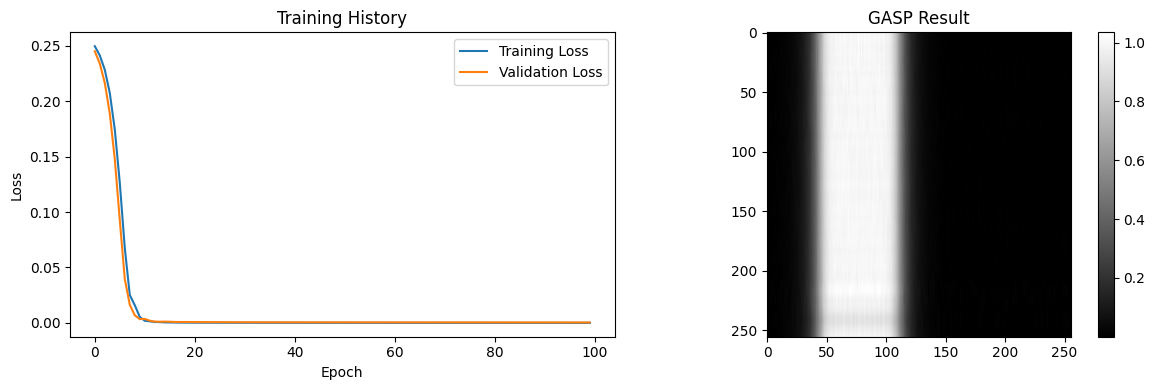

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

class GASPNeuralNetwork(models.Model):
    def __init__(self, input_shape, output_shape):
        super(GASPNeuralNetwork, self).__init__()
        
        self.dense1 = layers.Dense(64, activation='relu', input_shape=input_shape)
        self.dense2 = layers.Dense(32, activation='relu')
        self.dense3 = layers.Dense(32, activation='relu')
        self.output_layer = layers.Dense(output_shape, activation='linear')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.output_layer(x)

def prepare_data(M, D):
    # Assuming M is of shape (height, width, acquisitions)
    # and D is the desired spectral profile of shape (width,)
    
    # Reshape M to (pixels, acquisitions)
    height, width, acquisitions = M.shape
    M_reshaped = M.reshape(-1, acquisitions)
    
    # Prepare D as the target
    D_repeated = np.tile(D, (height * width, 1))
    
    return M_reshaped, D_repeated

def train_gasp_model(M, D, epochs=100, batch_size=32):
    # Prepare data
    X, y = prepare_data(M, D)
    
    # Define model
    input_shape = (X.shape[1],)
    output_shape = y.shape[1]
    model = GASPNeuralNetwork(input_shape, output_shape)
    
    # Compile model
    model.compile(optimizer='adam', loss='mse')
    
    # Train model
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    return model, history

def apply_gasp_model(model, M):
    # Prepare input data
    height, width, acquisitions = M.shape
    M_reshaped = M.reshape(-1, acquisitions)
    
    # Apply model
    output = model.predict(M_reshaped)
    
    # Reshape output to match original dimensions
    output_reshaped = output.reshape(height, width, -1)
    
    return output_reshaped

def generate_data():
    # Assuming M is of shape (height, width, acquisitions)
    # and D is the desired spectral profile of shape (width,)
    import sys
    sys.path.insert(0, '../../')  
    from gasp import simulate_ssfp_simple, sampling, responses, SSFPParams
    
    n = 48
    width = 256
    height = 1
    gradient = 2 * np.pi
    T2base = 0.01
    T1T2ratio = 5.0
    alpha = np.deg2rad(6)
    TRs = [5e-3, 10e-3, 20e-3]

    TRs, PCs = sampling.grid_TR_sampling(n_points=n, TRs=TRs)
    params = SSFPParams(n, alpha, TRs, PCs)
    M = simulate_ssfp_simple(width=width, height=height, T1=T1T2ratio * T2base, T2 = T2base, params=params, minTR = np.min(params.TRs), gradient = gradient)
    
    D = responses.bandpass(width, bw=0.25, shift=-0.2)

    return M, D

# Example usage
if __name__ == "__main__":
    # Assuming M and D are already defined
    # M: simulated bSSFP signals of shape (height, width, acquisitions)
    # D: desired spectral profile of shape (width,)
    
    # Train the model
    M, D = generate_data()
    gasp_model, training_history = train_gasp_model(M, D)
    
    # Apply the model to new data
    new_M, _ = generate_data() # ... load or generate new data of shape (height, width, acquisitions)
    result = apply_gasp_model(gasp_model, new_M)
    
    # Visualize results
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(training_history.history['loss'], label='Training Loss')
    plt.plot(training_history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training History')
    
    plt.subplot(1, 2, 2)
    plt.imshow(np.abs(result[0,:,:]), cmap='gray')
    plt.title('GASP Result')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()

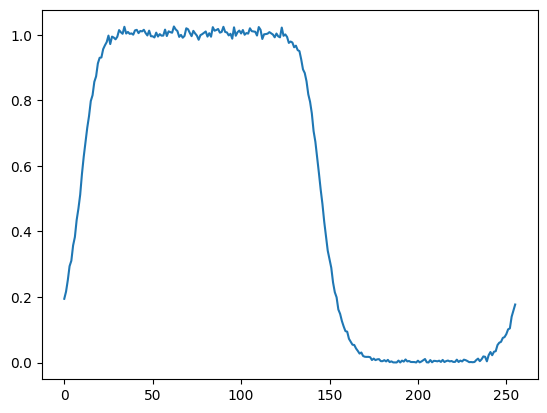

In [14]:
result[0].shape
plt.plot(np.abs(result[0][0,:]))

Epoch 1/100
640/640 [==============================] - 1s 1ms/step - loss: 0.1716 - val_loss: 0.1670
Epoch 2/100
640/640 [==============================] - 1s 970us/step - loss: 0.1674 - val_loss: 0.1670
Epoch 3/100
640/640 [==============================] - 1s 939us/step - loss: 0.1673 - val_loss: 0.1665
Epoch 4/100
640/640 [==============================] - 1s 961us/step - loss: 0.1672 - val_loss: 0.1675
Epoch 5/100
640/640 [==============================] - 1s 967us/step - loss: 0.1672 - val_loss: 0.1662
Epoch 6/100
640/640 [==============================] - 1s 947us/step - loss: 0.1672 - val_loss: 0.1646
Epoch 7/100
640/640 [==============================] - 1s 1000us/step - loss: 0.1672 - val_loss: 0.1686
Epoch 8/100
640/640 [==============================] - 1s 957us/step - loss: 0.1671 - val_loss: 0.1664
Epoch 9/100
640/640 [==============================] - 1s 1ms/step - loss: 0.1671 - val_loss: 0.1684
Epoch 10/100
640/640 [==============================] - 1s 969us/step - loss

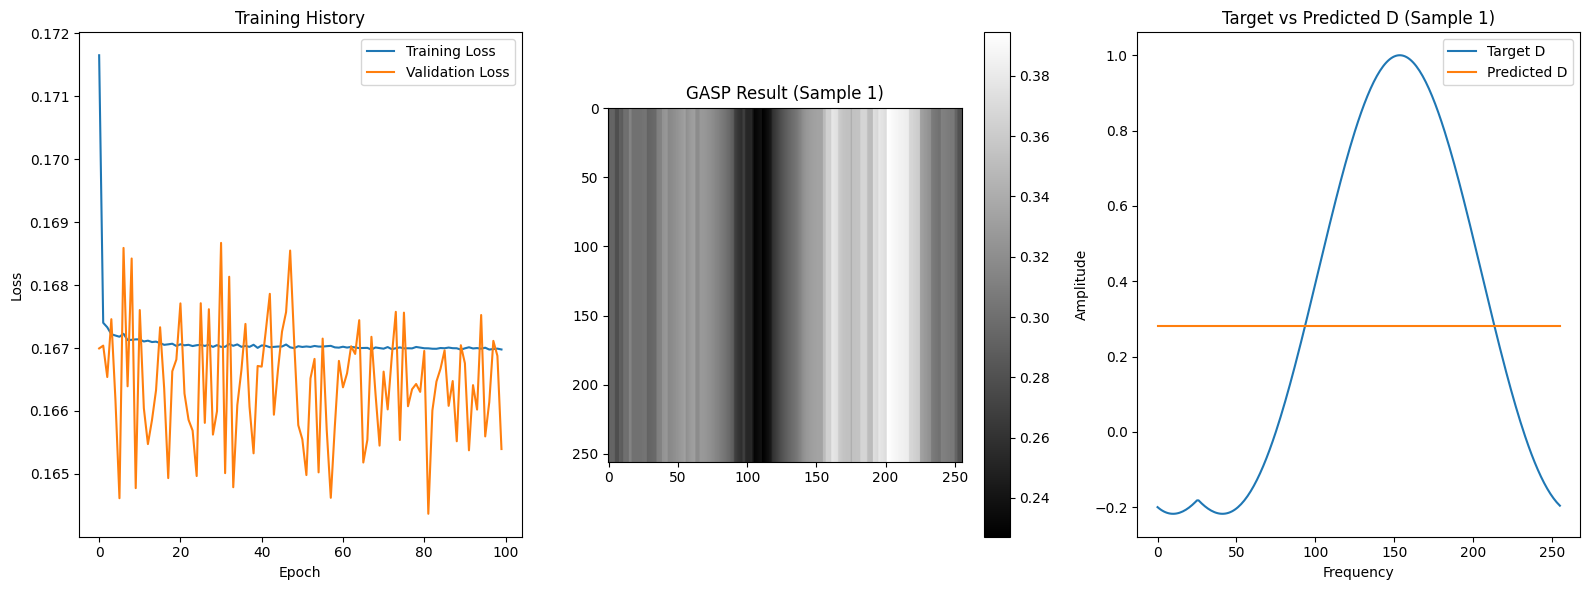

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from gasp import simulate_ssfp_simple, sampling, responses, SSFPParams

class GASPNeuralNetwork(models.Model):
    def __init__(self, input_shape, output_shape):
        super(GASPNeuralNetwork, self).__init__()
        
        self.dense1 = layers.Dense(64, activation='relu', input_shape=input_shape)
        self.dense2 = layers.Dense(32, activation='relu')
        self.dense3 = layers.Dense(32, activation='relu')
        self.output_layer = layers.Dense(output_shape, activation='linear')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.output_layer(x)

def prepare_data(M, D):
    # Assuming M is of shape (samples, height, width, acquisitions)
    # and D is of shape (samples, width)
    
    samples, height, width, acquisitions = M.shape
    
    # Reshape M to (samples * height * width, acquisitions)
    M_reshaped = M.reshape(-1, acquisitions)
    
    # Prepare D as the target
    D_repeated = np.repeat(D, height * width, axis=0)
    
    return M_reshaped, D_repeated

def train_gasp_model(M, D, epochs=100, batch_size=32):
    # Prepare data
    X, y = prepare_data(M, D)
    
    # Define model
    input_shape = (X.shape[1],)
    output_shape = y.shape[1]
    model = GASPNeuralNetwork(input_shape, output_shape)
    
    # Compile model
    model.compile(optimizer='adam', loss='mse')
    
    # Train model
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    return model, history

def apply_gasp_model(model, M):
    # Prepare input data
    samples, height, width, acquisitions = M.shape
    M_reshaped = M.reshape(-1, acquisitions)
    
    # Apply model
    output = model.predict(M_reshaped)
    
    # Reshape output to match original dimensions
    output_reshaped = output.reshape(samples, height, width, -1)
    
    return output_reshaped

def generate_varied_data(num_samples=100, width=256, height=1, n=48):
    gradient = 2 * np.pi
    T2base = 0.01
    T1T2ratio = 5.0
    alpha = np.deg2rad(6)
    TRs = [5e-3, 10e-3, 20e-3]

    TRs, PCs = sampling.grid_TR_sampling(n_points=n, TRs=TRs)
    params = SSFPParams(n, alpha, TRs, PCs)

    M_list = []
    D_list = []

    for _ in range(num_samples):
        # Generate M
        M = simulate_ssfp_simple(width=width, height=height, T1=T1T2ratio * T2base, T2=T2base, 
                                 params=params, minTR=np.min(params.TRs), gradient=gradient)
        M_list.append(M)

        # Generate varied D
        bw = np.random.uniform(0.1, 0.5)
        shift = np.random.uniform(-0.5, 0.5)
        filter_type = np.random.choice(['square', 'gaussian', 'sinc', 'lorentzian', 'butterworth'])
        D = responses.bandpass(width, bw=bw, shift=shift, type=filter_type)
        D_list.append(D)

    M_array = np.stack(M_list)
    D_array = np.stack(D_list)

    return M_array, D_array

# Example usage
if __name__ == "__main__":
    # Generate varied dataset
    M, D = generate_varied_data(num_samples=100)
    
    # Train the model
    gasp_model, training_history = train_gasp_model(M, D)
    
    # Generate new data for testing
    test_M, test_D = generate_varied_data(num_samples=10)
    
    # Apply the model to new data
    result = apply_gasp_model(gasp_model, test_M)
    
    # Visualize results
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 3, 1)
    plt.plot(training_history.history['loss'], label='Training Loss')
    plt.plot(training_history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training History')
    
    plt.subplot(1, 3, 2)
    plt.imshow(np.abs(result[0, 0, :, :]), cmap='gray')
    plt.title('GASP Result (Sample 1)')
    plt.colorbar()
    
    plt.subplot(1, 3, 3)
    plt.plot(test_D[0], label='Target D')
    plt.plot(result[0, 0, :, 0], label='Predicted D')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.title('Target vs Predicted D (Sample 1)')
    
    plt.tight_layout()
    plt.show()